# **6. Image Compression**

* PCA, SVD, DCT 등으로 이미지의 주요 정보만 사용해서 나타내는 방법을 알아보기.

* DCT는 JPEG, H.264 등 주요 영상 압축 알고리즘에 사용된다.

* 시각 정보는 색상보다 밝기에 민감해서, 보통 YCrCb에서 Y만 빼내어 압축한다.

* Chroma 정보도 압축하긴 하는데, 이 부분은 다루지 않음.

* 사실, DCT를 이용해 양자화, 부호화 등을 이용해서 전체적인 압축을 다 다루어야 하지만 image를 다루는 측면에서 집중해서 본다.

In [1]:
from sklearn.decomposition import PCA
from configs.config import BASE_PATH
from matplotlib import pyplot as plt
import imageio
import numpy as np
import cv2
import os

path = os.path.join(BASE_PATH,"data","image",'opencv_image5.jpg')
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img_ycrcb = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)

## **1.PCA**

* 영상 신호에서 공분산 행렬을 이용해서 주성분을 뽑아낸다.

* h,w의 영상신호이면 주성분은 최대 min(h,w)개를 가질 수 있다.

* 이 주성분들 중 major한 feature만 사용하고, 나머지 주성분은 사용하지 않고 이미지를 압축한다.

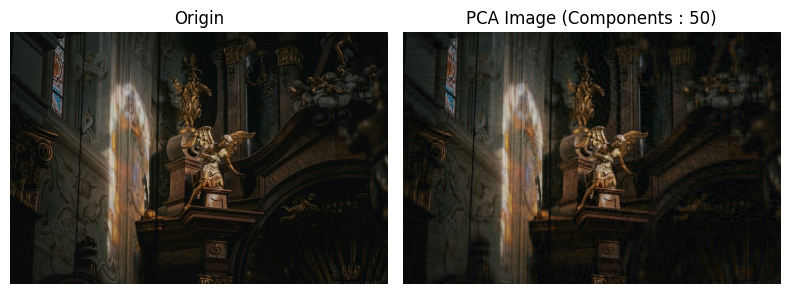

In [2]:
y,cr,cb = cv2.split(img_ycrcb)

h,w= y.shape

k = 50
pca = PCA(n_components=k)
y_pca = pca.fit_transform(y) 
y_ipca = pca.inverse_transform(y_pca) 
y_ipca = np.clip(y_ipca, 0, 255).astype(np.uint8)

img_pca_comp = cv2.merge([y_ipca, cr, cb])
img_pca_comp = cv2.cvtColor(img_pca_comp, cv2.COLOR_YCrCb2RGB)

fig,ax = plt.subplots(1,2,figsize=(8,8))
images = [img, img_pca_comp]
titles = ['Origin', f'PCA Image (Components : {k})']

for idx, (image,title) in enumerate(zip(images, titles)):
    ax[idx].imshow(image)
    ax[idx].set_title(title)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

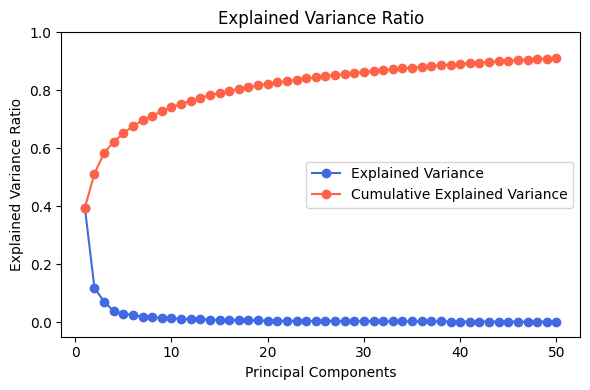

In [3]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(range(1,k+1), explained_variance, marker='o', linestyle='-', color='royalblue', label='Explained Variance')
ax.plot(range(1,k+1), cumulative_explained_variance, marker='o', linestyle='-', color='tomato', label='Cumulative Explained Variance')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio')
ax.set_ylim([-0.05,1])
ax.legend(loc='right')
plt.tight_layout()
plt.show()

* 20개의 성분만 사용해도 80% 이상의 정보를 얻을 수 있다.

* threshold를 통해서 특정 퍼센티지가 넘어가는 변수까지만 선택하는 방법이 일반적이다.
  
* 보통 설명변수가 0.8정도가 되면 원본 이미지의 정보를 대부분 담고있다.
  
* 0.9정도가 되면 거의 차이가 없다.

## **2. SVD**

* 행렬을 3개의 행렬로 분해한다.

* 대각행렬의 상위 x개의 feature를 사용해서 영상을 압축한다.

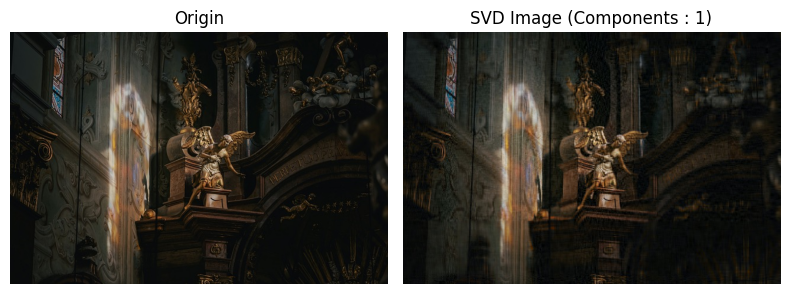

In [4]:
y,cr,cb = cv2.split(img_ycrcb)

k = 1
img_svd = np.linalg.svd(y, full_matrices=False)
U,S,VT = img_svd
S = np.diag(S)
U_k = U[:,:k]
S_k = S[:k,:k]
VT_k = VT[:k,:]

img_isvd = np.dot(U_k, np.dot(S_k, VT_k))
img_isvd = np.clip(img_isvd, 0, 255).astype(np.uint8)

img_svd_comp = cv2.merge([y_ipca, cr, cb])
img_svd_comp = cv2.cvtColor(img_svd_comp, cv2.COLOR_YCrCb2RGB)

images = [img, img_svd_comp]
titles = ['Origin', f'SVD Image (Components : {k})']

fig,ax = plt.subplots(1,2,figsize=(8,8))
for idx, (image,title) in enumerate(zip(images, titles)):
    ax[idx].imshow(image)
    ax[idx].set_title(title)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

* PCA와 다르게 기본적으로 하나의 특이값만 사용해도 굉장히 많은 정보를 포함한다.

In [5]:
explained_variance.cumsum()

array([0.39535241, 0.51293528, 0.58412214, 0.62199229, 0.65161873,
       0.67691848, 0.69602476, 0.71244909, 0.72730078, 0.74162209,
       0.75282522, 0.76375575, 0.77413697, 0.78285422, 0.79063806,
       0.79799935, 0.80459687, 0.81081666, 0.81684541, 0.82217635,
       0.82716068, 0.83196351, 0.8365928 , 0.84091914, 0.84509288,
       0.84915941, 0.85295228, 0.85650091, 0.85996819, 0.86330705,
       0.86657093, 0.86970863, 0.87266724, 0.8755623 , 0.87836131,
       0.88108952, 0.8837311 , 0.88627233, 0.88872405, 0.89113006,
       0.89345724, 0.8957714 , 0.89791521, 0.90000656, 0.90202255,
       0.90402557, 0.90595929, 0.90787339, 0.90967247, 0.91140002])

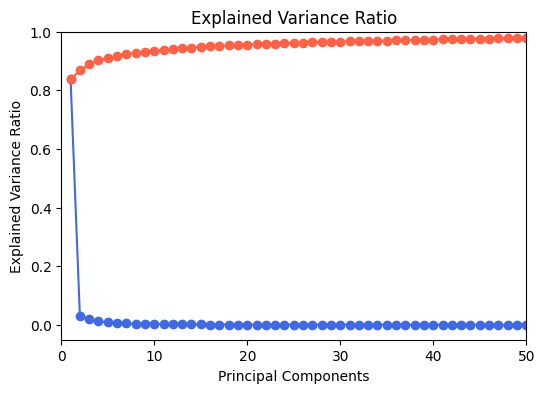

In [6]:
explained_variance = (S**2) / np.sum(S**2)
explained_variance = np.array([sum(v) for v in explained_variance])
cumulative_explained_variance = explained_variance.cumsum()

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, len(cumulative_explained_variance)+1), explained_variance, color='royalblue', marker='o', label='Explained Variance')
ax.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, color='tomato', marker='o', label='Cumulative Explained Variance')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio')
ax.set_xlim([0,50])
ax.set_ylim([-0.05,1])
plt.show()

## **3. DCT**

* cosine transform을 이용한다.

* Frequency Domain으로의 번환이므로 고주파 대역의 정보를 날려서 데이터를 압축한다.

* 고주파 대역이 차지하는 정보는 많지만, 이미지에서는 차이가 크게 나지 않는다.

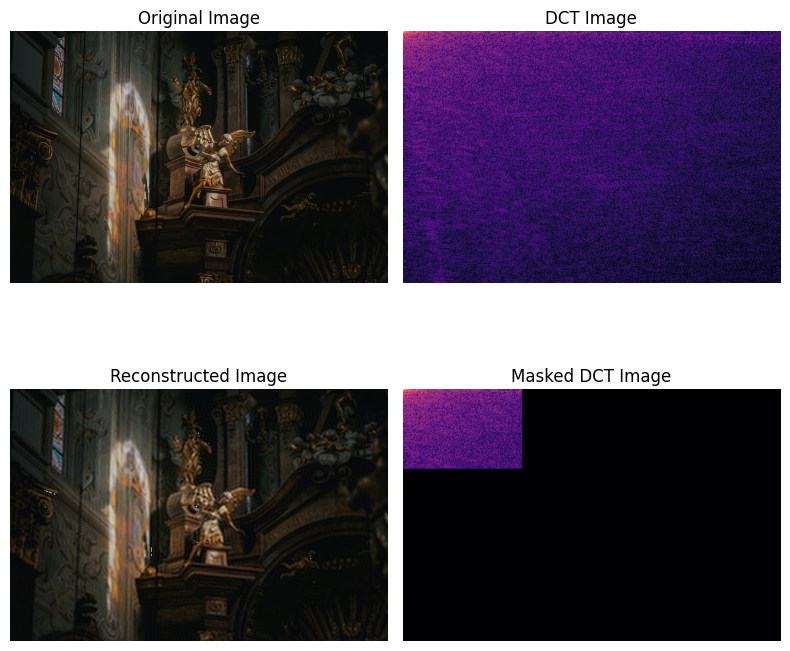

In [7]:
def DCT(img):
    return cv2.dct(np.float32(img))

def IDCT(img_dct):
    return cv2.idct(img_dct).astype(np.uint8)

def magnitude(img_dct):
    magnitude = 20 * np.log(np.abs(img_dct) + 1)
    return magnitude

def get_mask(img_dct, k: int):
    h, w = img_dct.shape
    ratio = np.sqrt(k/100)
    mask = np.zeros((h,w), np.float32)
    mask[:int(h*ratio), :int(w*ratio)] = 1
    return mask

y,cr,cb = cv2.split(img_ycrcb)
img_dct = DCT(y)

img_dct_masked = img_dct * get_mask(img_dct,10)
img_reconstrunted = cv2.merge([IDCT(img_dct_masked),cr,cb])
img_reconstrunted = cv2.cvtColor(img_reconstrunted,cv2.COLOR_YCrCb2RGB)


fig, ax = plt.subplots(2,2, figsize=(8,8))
images = [img, magnitude(img_dct), img_reconstrunted, magnitude(img_dct_masked)]
titles = ['Original Image', 'DCT Image', 'Reconstructed Image', 'Masked DCT Image']

for idx, (image,title) in enumerate(zip(images, titles)):
    h,w = divmod(idx,2)
    ax[h,w].imshow(image, cmap='magma' if 'DCT' in title else None)
    ax[h,w].set_title(title)
    ax[h,w].axis('off')
    
plt.tight_layout()
plt.show()